In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from joblib import dump, load

file_path = Path.cwd().joinpath("Data", "mpr_data_merged")
output_path = os.path.join(os.path.expanduser("~"), "documents/queensma/ma_essay/data/output")

# PLOTTING
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set_theme(style='ticks', palette='muted', font="Arial", font_scale=1) # set theme
plt.rc("axes.spines", top=False, right=False) # remove top and right spines for all charts
# palette = sns.cubehelix_palette(start=1, rot=1, as_cmap=False, n_colors=20, dark=0.5)

## SKLEARN ##
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics

## XGBOOST ##
from xgboost import XGBClassifier

In [2]:
# import matplotlib.font_manager
# from IPython.core.display import HTML

# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

# Import

In [3]:
## Read in the MPR data file ##
df = pd.read_csv(file_path.joinpath('data_model_ready_V3.csv'))

In [4]:
df

,text,class,mpr,wordcount,NPositiveWords,NNegativeWords,NNeutralWords,NUncertainWords,NStrongWords,NWeakWords,...,Poswords,Negwords,Neuwords,Unwords,Strongwords,Weakwords,Conwords,quarter,year,raw_text
0,information received since last monetary polic...,2,2000Q1,41,1,0,41,0,0,0,...,stronger,NaN,information received since the last monetary p...,NaN,NaN,NaN,NaN,1,2000,Information received since the last Monetary P...
1,strengthening global demand world prices non a...,2,2000Q1,25,1,0,25,0,0,0,...,strengthening,NaN,with the further strengthening of global deman...,NaN,NaN,NaN,NaN,1,2000,With the further strengthening of global deman...
2,particularly true oil lumber nickel production...,2,2000Q1,18,0,0,17,0,0,0,...,NaN,NaN,this has been particularly true for oil lumber...,NaN,NaN,NaN,constraints,1,2000,"This has been particularly true for oil, lumbe..."
3,higher crude oil prices led higher energy pric...,0,2000Q1,25,0,0,25,0,0,0,...,NaN,NaN,higher crude oil prices have led to higher ene...,NaN,NaN,NaN,NaN,1,2000,Higher crude oil prices have led to higher ene...
4,yet however countries not seen significant inc...,1,2000Q1,26,0,0,26,0,0,0,...,NaN,NaN,as yet however these countries have not seen a...,NaN,NaN,NaN,NaN,1,2000,"As yet, however, these countries have not seen..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17311,limited tightening financial conditions due re...,0,2023Q2,20,0,2,20,0,0,0,...,NaN,tightening stress,the limited tightening in financial conditions...,NaN,NaN,NaN,NaN,2,2023,The limited tightening in financial conditions...
17312,however global banking stresses intensify glob...,0,2023Q2,13,0,1,13,1,0,1,...,NaN,stresses,however if global banking stresses intensify f...,could,NaN,could,NaN,2,2023,"However, if global banking stresses intensify ..."
17313,risk materializes severe global slowdown sharp...,0,2023Q2,16,0,3,16,2,0,1,...,NaN,severe slowdown sharply,if this risk materializes a more severe global...,risk could,NaN,could,NaN,2,2023,"If this risk materializes, a more severe globa..."
17314,canadian economy would affected tighter financ...,0,2023Q2,26,0,2,26,0,0,0,...,NaN,weaker declines,the canadian economy would be affected through...,NaN,NaN,NaN,NaN,2,2023,The Canadian economy would be affected through...


In [5]:
# from sklearn.feature_extraction.text import CountVectorizer

# string = ["the cat chased the mouse all around the house until it got caught"]
# input_str = ["the cat chased the mouse"]

# count_vec = CountVectorizer()
# count_vec.fit(X_train['text'])

# # print(count_vec.vocabulary_)
# result = count_vec.transform(X_train['text'])
# print(result.toarray())
# result

In [6]:
# tfid = TfidfVectorizer()
# tfid.fit(X_train['text'])
# # print(tfid.vocabulary_)
# result = tfid.transform(X_train['text'])
# print(result.toarray())
# result

# EDA

## Distribution of class labels

In [7]:
# fig, ax = plt.subplots(figsize=(9,6))

# plt.bar(
#     height=df['class'].value_counts().sort_index()/len(df), 
#     x=['negative', 'neutral', 'positive'],
#     color=sns.color_palette()
# )
# plt.tight_layout()

# Split Data

In [8]:
y = df['class']
X = df[
    ['text', 
     'year',
     'quarter',
     'wordcount', 
     'NPositiveWords', 
     'NNegativeWords', 
     'NUncertainWords', 
     'NConstWords', 
     'NStrongWords', 
     'NWeakWords']
]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

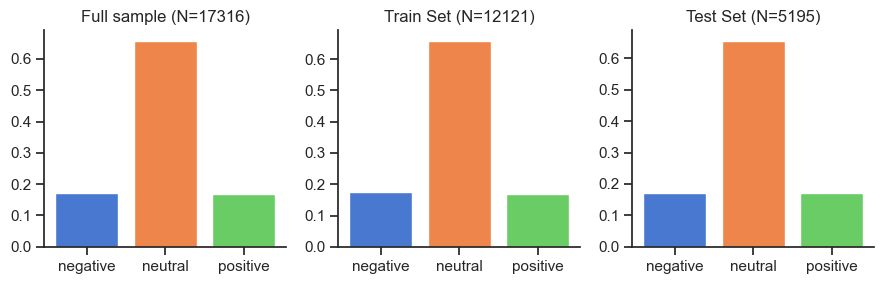

In [9]:
# Check distributions for TRAIN and TEST sets
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

# fig.suptitle("Target Balance")

ax[0].set_title(f"Full sample (N={len(df)})")
ax[0].bar(
    height=df['class'].value_counts().sort_index()/len(df), 
    x=['negative', 'neutral', 'positive'],
    color=sns.color_palette(),
)

ax[1].set_title(f"Train Set (N={len(y_train)})")
ax[1].bar(
    height=y_train.value_counts().sort_index()/len(y_train), 
    x=['negative', 'neutral', 'positive'],
    color=sns.color_palette()
)

ax[2].set_title(f"Test Set (N={len(y_test)})")
ax[2].bar(
    height=y_test.value_counts().sort_index()/len(y_test), 
    x=['negative', 'neutral', 'positive'],
    color=sns.color_palette()
)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "charts", "sample_balance.png"), dpi=300)

# Sklearn Models

In [10]:
# GET AUC score
# need to reshape y_test data
def reshape_labels(data):
    """
    Reshape y labels from 1D vector to a matrix
    with shape (n, number of labels).
    
    In other words one-hot encode label vector.
    """
    data = pd.DataFrame(data)
    data[0] = data['class'].apply(lambda x: 1 if x == 0 else 0)
    data[1] = data['class'].apply(lambda x: 1 if x == 1 else 0)
    data[2] = data['class'].apply(lambda x: 1 if x == 2 else 0)
    return data.loc[:, 0:]

def prob_prediction(model, X_test):
    """
    X_test: Should be a 1D array 
    
    ie: [0, 1, 1, 2]
    
    return the predicted probabilities for each label
    """
    return model.predict_proba(X_test)

def calc_auc_score(y_test, predicted_prob):
    """
    X_test: Should be a 1D array 
    
    ie: [0, 1, 1, 2]
    
    Transform X_test to a one-hot encoded array
    ie: shape = (n, number of labels)
    
    Calculate roc_auc_score
    """
    y_test_wide = reshape_labels(y_test)
    return metrics.roc_auc_score(y_test_wide, predicted_prob, multi_class='ovr', average='weighted')

In [11]:
preprocessor = ColumnTransformer(
    [
        ('tfidf', TfidfVectorizer(), 'text'),
    ],
    remainder='passthrough'
)

In [12]:
logit_clf = Pipeline(
    [
        ('preprocess', preprocessor),
        ('clf', LogisticRegression(random_state=0, n_jobs=-1, solver='lbfgs', max_iter=50000, multi_class='ovr'))
    ]
)
logit_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'text')])),
                ('clf',
                 LogisticRegression(max_iter=50000, multi_class='ovr',
                                    n_jobs=-1, random_state=0))])

In [13]:
pred = logit_clf.predict(X_test)

# CREATE TABLE #
report = pd.DataFrame(
    metrics.classification_report(
        y_test, pred, 
        target_names=['negative', 'neutral', 'positive'], 
        digits=3,
        output_dict=True
    )
)
display(report)
print(f"AUC: {calc_auc_score(y_test, prob_prediction(logit_clf, X_test)):.3f}")

## SAVE REPORT ##
# report.to_csv(os.path.join(output_path, "tables", "logit_report.csv"))

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.709677,0.776382,0.675630,0.756882,0.720563,0.747577
recall,0.492721,0.906690,0.449664,0.756882,0.616359,0.756882
f1-score,0.581626,0.836492,0.539960,0.756882,0.652692,0.741651
support,893.000000,3408.000000,894.000000,0.756882,5195.000000,5195.000000


AUC: 0.854


In [14]:
rf_clf = Pipeline(
    [
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=45))
    ]
)

rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'text')])),
                ('clf',
                 RandomForestClassifier(n_estimators=45, n_jobs=-1,
                                        random_state=0))])

In [15]:
pred = rf_clf.predict(X_test)
# print(metrics.classification_report(y_test, pred))
# print(f"AUC: {calc_auc_score(y_test, prob_prediction(rf_clf, X_test)):.3f}")

# CREATE TABLE #
report = pd.DataFrame(
    metrics.classification_report(
        y_test, pred, 
        target_names=['negative', 'neutral', 'positive'], 
        digits=3,
        output_dict=True
    )
)
display(report)
print(f"AUC: {calc_auc_score(y_test, prob_prediction(rf_clf, X_test)):.3f}")

## SAVE REPORT ##
# report.to_csv(os.path.join(output_path, "tables", "rf_report.csv"))

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.816901,0.757293,0.735537,0.760154,0.769910,0.763795
recall,0.389698,0.952171,0.398210,0.760154,0.580026,0.760154
f1-score,0.527672,0.843624,0.516691,0.760154,0.629329,0.733052
support,893.000000,3408.000000,894.000000,0.760154,5195.000000,5195.000000


AUC: 0.866


In [16]:
xgb_clf = Pipeline(
    [
        ('preprocess', preprocessor),
        ('clf', XGBClassifier(
            random_state=0, 
            n_jobs=-1, 
            n_estimators=120, 
            objective='gbtree'))
    ]
)

xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'text')])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=120,
                               n_jobs=-1, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [17]:
### HYPTER TUNING XGBOOST ###
# # Distribution of parameters to choose from during RandomSearchCV
# param_dist = {
#     "clf__n_estimators": np.arange(50, 120),
#     "clf__subsample": np.linspace(0.5, 1),
#     "clf__reg_lambda": np.linspace(0.001, 0.2),
#     "clf__learning_rate": np.linspace(0.0001, 0.1)
# }

# rs = RandomizedSearchCV(
#     xgb_clf, 
#     param_distributions=param_dist, 
#     n_iter=20,
#     refit='accuracy',
#     random_state=0, 
#     n_jobs=-1, 
#     cv=5,
#     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
#     verbose=1
# )
# rs.fit(X_train, y_train)

# print(f"Best Accuracy Score: {rs.best_score_}\nBest Parameters: {rs.best_params_}")

# best_xgb_model = rs.best_estimator_
# dump(best_xgb_model, "/Users/kelstonchen/Documents/QueensMA/MA_Essay/MODELS/xgboost_model.joblib")

In [18]:
# LOAD THE MODEL AFTER HYPERTUNING
xgb_clf = load("/Users/kelstonchen/Documents/QueensMA/MA_Essay/MODELS/xgboost_model.joblib")

# PREDICT ON TEST DATA
pred = xgb_clf.predict(X_test)
# print(metrics.classification_report(
#     y_test, pred, 
#     target_names=['negative', 'neutral', 'positive'], 
#     digits=3,
#     output_dict=True
# )
#      )

report = pd.DataFrame(
    metrics.classification_report(
        y_test, pred, 
        target_names=['negative', 'neutral', 'positive'], 
        digits=3,
        output_dict=True
    )
)
display(report)
print(f"AUC: {calc_auc_score(y_test, prob_prediction(xgb_clf, X_test)):.3f}")

## SAVE REPORT ##
# report.to_csv(os.path.join(output_path, "tables", "xgboost_report.csv"))

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.835443,0.788736,0.740458,0.78691,0.788212,0.788457
recall,0.443449,0.941021,0.542506,0.78691,0.642325,0.786910
f1-score,0.579371,0.858175,0.626210,0.78691,0.687919,0.770331
support,893.000000,3408.000000,894.000000,0.78691,5195.000000,5195.000000


AUC: 0.876


In [19]:
## BALANCED ACCURACY ##
metrics.balanced_accuracy_score(y_test, pred)

0.6423252559180074

# NO SKILL score

In [20]:
# NO SKILL SCORES; predicting the most common class (=1) for all cases.
print(
    metrics.classification_report(
        y_test, 
        ([1] * len(y_test))
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       893
           1       0.66      1.00      0.79      3408
           2       0.00      0.00      0.00       894

    accuracy                           0.66      5195
   macro avg       0.22      0.33      0.26      5195
weighted avg       0.43      0.66      0.52      5195



/Users/kelstonchen/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelstonchen/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelstonchen/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

0.3333333333333333